In [1]:
import pandas as pd
import os
import seaborn as sns
import glob
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import re
import numpy as np

# Logistic Regression

In [2]:
train_data_df = pd.read_csv("data/processed_train_time_balanced_df.csv", index_col=0)
y_train = train_data_df['label']
X_train = train_data_df['processed_bodies']

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
lr_pipe = Pipeline([
    ('cv', CountVectorizer(min_df=.004, max_df=.4, ngram_range=(2, 3), stop_words='english')),
    ('lr', LogisticRegression(max_iter=2000))
])

In [4]:
lr_pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.4,
                                 max_features=None, min_df=0.004,
                                 ngram_range=(2, 3), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=2000,
                                    multi_class='warn', n_jobs=None,
                   

In [5]:
test_data_df = pd.read_csv("data/processed_test_time_unbalanced_df.csv", index_col=0)
y_test = test_data_df['label']
X_test = test_data_df['processed_bodies']

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
y_pred = lr_pipe.predict_proba(X_test)

In [7]:
pd.Series(np.argmax(y_pred, axis=1)).value_counts()

0    197623
1     59845
dtype: int64

In [8]:
roc_auc_score(y_test, y_pred[:, 1])

0.8392580232245256

In [9]:
pipe_steps = dict(lr_pipe.steps)

length of vocabulary

In [10]:
len(pipe_steps['cv'].vocabulary_)

2806

bigrams vs. trigrams

In [11]:
pd.Series(pipe_steps['cv'].vocabulary_).reset_index()['index'].str.split().str.len().value_counts()

2    2515
3     291
Name: index, dtype: int64

AUCS (old -- tested on balanced data)

LR, min_df = .01, max_df = .4, unigrams, with stopwords, vocab size=1,300, AUC=.84

LR, min_df = .01, max_df = .4, trigrams, without stopwords, vocab size=100, AUC=.64

LR, min_df = .001, max_df = .4, trigrams, without stopwords, vocab size=2,700, AUC=.84

LR, min_df = .001, max_df = .4, trigrams, processed, vocab size=2,700, AUC=.81

LR, min_df = .001, max_df = .4, bigrams and trigrams, processed, vocab size=23,696, AUC=.81

LR, min_df = .01, max_df = .4, bigrams and trigrams, processed, vocab size=500, AUC=.83

In [12]:
model_str = "mindf-004-maxdf-4"

In [13]:
word_counts = pipe_steps['cv'].transform(X_train)
voc = pd.Series(pipe_steps['cv'].vocabulary_).sort_values().index

## coefficient series
coef_s = pd.Series(
    pipe_steps['lr'].coef_[0],
    index=voc,
)
## word count series 
word_counts_s = pd.Series(np.array((word_counts == 1).sum(axis=0)).ravel(), index=voc)
coef_df = pd.concat([
    word_counts_s.to_frame('counts'),
    coef_s.to_frame('coef')
], axis=1)

In [14]:
coef_df.to_csv('models/2019-08-27__%s__cv-lr.csv' % model_str)

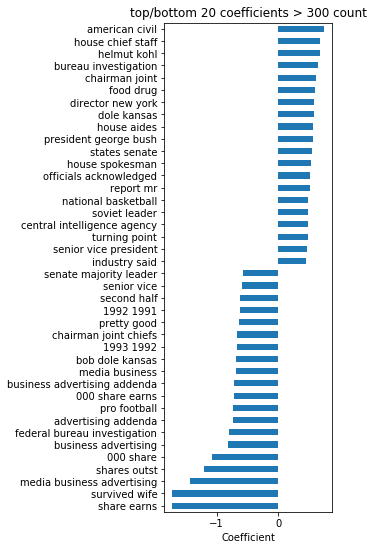

In [15]:
top_k = 20
figsize= (3,9)
cutoff = 300

(coef_df
 .loc[lambda df: df['counts'] > cutoff]['coef']
 .sort_values()
 .pipe(lambda s: pd.concat([s[:top_k], s[-top_k:]]))
 .plot(kind='barh', figsize=figsize, title='top/bottom %d coefficients > %d count' % (top_k, cutoff))
)
plt.xlabel('Coefficient')
plt.savefig('models/2019-08-27__%s__top-coefficients-cutoff-%d.png' % (model_str, cutoff), bbox_inches='tight')

In [16]:
def find_nearest_idx(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    return np.abs(a - a0).argmin()

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    return a[np.abs(a - a0).argmin()]

In [17]:
spacing = np.linspace(coef_df['coef'].min(), coef_df['coef'].max(), num=6)

In [ ]:
x_ticks = list(map(lambda x: find_nearest(coef_df['coef'], x), spacing))
word_ticks = list(map(lambda x: find_nearest_idx(coef_df['coef'], x), spacing))

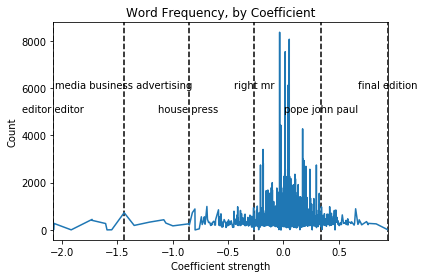

In [19]:
coef_df.sort_values('coef', ascending=False).set_index('coef')['counts'].plot(title="Word Frequency, by Coefficient")
plt.xlabel('Coefficient strength')
plt.ylabel('Count')

ylim = plt.ylim()
v_space = [5000, 6000]
for i, (x_t, w_t) in enumerate(zip(x_ticks, word_ticks)):
    plt.text(x_t, v_space[i%2], w_t, horizontalalignment='center')
    plt.vlines(x_t, *ylim, linestyles='dashed')
plt.ylim(ylim)
plt.savefig('models/2019-08-27__%s__coefficients-and-frequency.png' % model_str, bbox_inches='tight')